In [1]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision

from tqdm import tqdm, trange
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import datasetclass
from utils import *
from models import network


In [7]:
'''
Codes Below were used to do a final preprocessing and save the final ready data in final_ready
'''

'\nCodes Below were used to do a final preprocessing and save the final ready data in final_ready\n'

```python
df = pd.read_csv("./preprocessing/final_data_pictures.csv", sep=';').drop(['Unnamed: 0', 'alias', 'url'], axis=1)
paths = df['path']
df = df.iloc[:, :9]
df = pd.concat([df, paths], axis=1)
df.head()
encoder = OneHotEncoder()
weekdays = df['weekday'].values.reshape(-1, 1)
encoder.fit(weekdays)
one_hot_encoded = encoder.transform(weekdays).toarray().astype(np.int8)
df.drop(['weekday'], axis=1, inplace=True)
encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['weekday']))
encoded_df = pd.concat([df, encoded_df], axis=1)
#encoded_df['multipleImage'] = encoded_df['multipleImage'].astype(np.int8)

print(len(encoded_df.keys()))
encoded_df.head()
'''

```python
df = pd.read_csv("./preprocessing/final_data.csv", sep=';').drop(['Unnamed: 0', 'alias', 'descriptionProcessed'], axis=1)
encoder = OneHotEncoder()
weekdays = df['weekday'].values.reshape(-1, 1)
encoder.fit(weekdays)
one_hot_encoded = encoder.transform(weekdays).toarray().astype(np.int8)
df.drop(['weekday'], axis=1, inplace=True)
encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['weekday']))
encoded_df = pd.concat([df, encoded_df], axis=1)
encoded_df['multipleImage'] = encoded_df['multipleImage'].astype(np.int8)

print(len(encoded_df.keys()))
encoded_df.describe()
```

```python
path = './preprocessing/final_data_ready.csv'
encoded_df.to_csv(path = './preprocessing/final_data_ready.csv')
```

# Training

In [4]:
# Final dataset that we load should contain only numerical numbers, so the categorical should be converted to onehot encodings.
# The attributes are as follows:
# multipleImage,numberLikesCategory,amount_relevant_tags,moving_avg,numberPosts,numberFollowers,numberFollowing,website_available
# where numberLikesCategory are the labels
path = './preprocessing/final_data_pictures_ready.csv'
#device = ('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

dataset_train = datasetclass.InstagramUserData(path, sep=';', device=device, train=True)
dataset_test = datasetclass.InstagramUserData(path, sep=';', device=device, train=False)
dataset_train.__len__(), dataset_test.__len__()

(4364, 485)

In [3]:
[(i.dtype, i.shape) for i in dataset_train.__getitem__(0)]

[(torch.float32, torch.Size([13, 1])),
 (torch.float32, torch.Size([3, 640, 640])),
 (torch.int64, torch.Size([]))]

```python
def collate_fn(batch, img_size=(256,256)):
    
    resizer = Resize(img_size)
    datas, imgs, labels = zip(*batch)

    # Resizing images to img_size
    imgs_resized = []
    for sample in batch:
        _, img, _ = sample
        img = resizer(img).to(torch.float32)
        assert img.shape == (3, 256, 256), f"img.shape is {img.shape} but should have been 3, 256,256"
        imgs_resized.append(img)

    # Return eveuthing as tensors
    batch = (torch.stack(datas), torch.stack(imgs_resized), torch.stack(labels).to(torch.long))
    return batch
    ```

```python output
Unsupported image file. Only jpeg and png are currently supported. in pictures/hotelsandresorts/4.jpg
```
changd the image which was corrupted with 5.jpg

In [10]:
# Create Dataloader
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=collate_fn)
# Test Dataloaders
# for i, batch in enumerate(tqdm(train_loader)):
#     pass
# for i, batch in enumerate(tqdm(test_loader)):
#     pass
some_data, some_image, some_label = next(iter(train_loader))
in_dim = some_data.shape[1]
image_in_dim = some_image.shape[1]
some_data.shape,  some_image.shape, some_label.shape, some_data.dtype, some_image.dtype, some_label.dtype

c:\Users\SysSec\.conda\envs\instalike\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([32, 13, 1]),
 torch.Size([32, 3, 256, 256]),
 torch.Size([32]),
 torch.float32,
 torch.float32,
 torch.int64)

# Neural Net


In [11]:
# Load the neural network
model = network.LikeCategoryPredictor(in_dim=in_dim, image_in_dim=image_in_dim, out_classes=10).to(device=device)
print(model)

c:\Users\SysSec\.conda\envs\instalike\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\SysSec\.conda\envs\instalike\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LikeCategoryPredictor(
  (feature): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=13, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
  )
  (image_embedder): ImageEmbedder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [12]:
# image_embedder = network.ImageEmbedder(in_dim=image_in_dim, weights=torchvision.models.ResNet18_Weights)
# image_embedder(some_image).shape

In [13]:
# First Check if everything is compatible then:
some_data = some_data.to(device)
some_image = some_image.to(device)
out = model((some_data, some_image))
out.shape
# Testing Done!

torch.Size([32, 10])

In [14]:
# Training
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=.0005)

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, batch in enumerate(tqdm(train_loader)):
        # Every data instance is an input + label pair
        data, img, y = batch
        data, img, y = data.to(device), img.to(device), y.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model((data, img))

        # Compute the loss and its gradients
        loss = criterion(outputs, y.to(torch.long))
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss, running_loss


In [ ]:
epoch_number = 0
Epochs = 50
avg_loss = 0
running_vloss = 0.0

for epoch in range(Epochs):
    model.train(True)
    last_loss, running_loss = train_one_epoch(epoch_number)
    avg_loss += running_loss

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            data, img, vlabels = vdata
            vinputs = (data.to(device), img.to(device))
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels.to(torch.long))
            running_vloss += vloss
        print(f"Validation loss at epoch {epoch_number+1} is {vloss}")

    epoch_number += 1

avg_loss = avg_loss/Epochs
running_vloss = running_vloss/Epochs
print(f"avg loss {avg_loss} and avg_val_loss {running_vloss}")

In [10]:
some_output = model(some_data)
some_output.shape

torch.Size([10, 10])

In [11]:
torch.argmax(some_output, dim=1)

tensor([7, 3, 4, 3, 1, 4, 3, 3, 2, 3])

In [12]:
some_label

tensor([7., 1., 4., 6., 1., 4., 1., 3., 2., 3.])

In [13]:
criterion(some_output, some_label.to(torch.long))

tensor(1.6676, grad_fn=<NllLossBackward0>)

In [18]:
def calculate_accuracy(predicted_labels, true_labels):
    total_samples = len(true_labels)
    correct_predictions = (predicted_labels == true_labels).sum().item()
    accuracy = correct_predictions / total_samples
    return accuracy

print(calculate_accuracy(torch.argmax(some_output, dim=1), some_label)*100, '%')

# ML Algs Comparison

In [24]:
from sklearn.svm import SVC

clf_ovo = SVC(decision_function_shape='ovo')
clf_ovr = SVC(decision_function_shape='ovr')

In [25]:
x = np.array(dataset_train.dataframe)
# some_x, some_y = x[:1, :], y[0]
# print(some_x.shape, some_y.shape)
y = np.array(dataset_train.labels).reshape(-1,)
print(x.shape, y.shape)
#clf_ovo.fit(x, y)
clf_ovr.fit(x, y)

(5682, 514) (5682,)


SVC()

In [26]:
ovr_pred = clf_ovr.decision_function(x)
#ovo_pred = clf_ovo.decision_function(x)
ovr_pred.shape#, ovo_pred.shape

((5682, 10), (5682, 45))

In [31]:
np.argmax(ovr_pred[0:10], axis=1), y[0:10]

(array([8, 1, 1, 2, 8, 1, 1, 1, 1, 5], dtype=int64),
 array([6, 3, 4, 1, 7, 1, 1, 2, 3, 4], dtype=int64))

In [28]:
print(calculate_accuracy(np.argmax(ovr_pred, axis=1), y)*100, '%')

20.34494896163323 %


In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf_clf.fit(x, y)

RandomForestClassifier(max_depth=5)

In [52]:
rf_pred = rf_clf.predict(x)
print(calculate_accuracy(rf_pred, y)*100, '%')

43.153819077789514 %


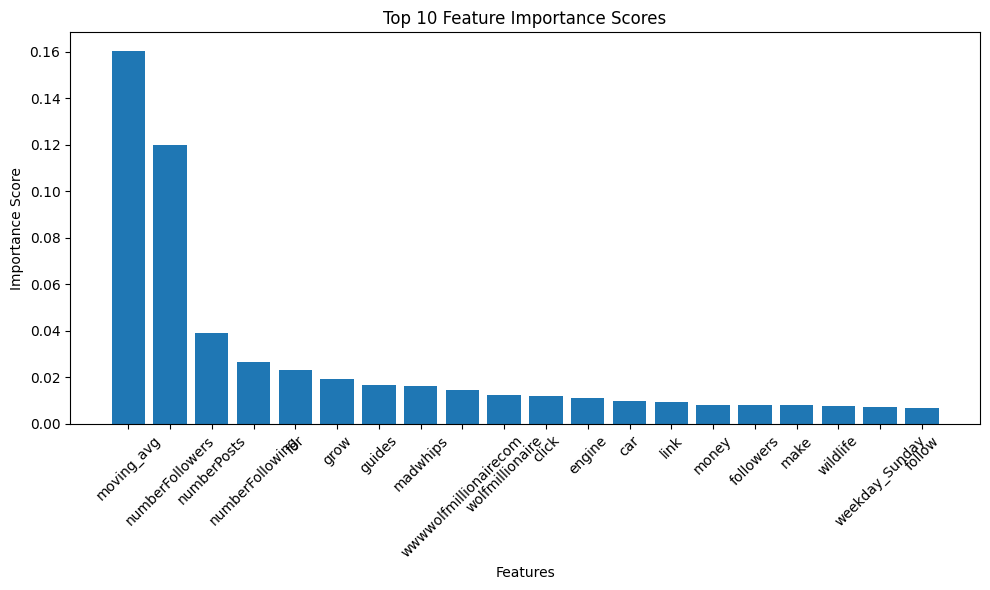

In [63]:
import matplotlib.pyplot as plt

# Retrieve the feature importances
importances = {dataset_train.data.keys()[i]: rf_clf.feature_importances_[i] for i in range(len(dataset_train.data.keys()))}

# Sort the feature importances in descending order
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Retrieve the top 10 feature importances
top_features = dict(sorted_importances[:20])
top_feature_names = list(top_features.keys())
top_scores = list(top_features.values())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_scores)), top_scores, align='center')
plt.xticks(range(len(top_scores)), top_feature_names, rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Top 10 Feature Importance Scores')
plt.tight_layout()
plt.show()


In [64]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=.002, max_depth=5)
gb_clf.fit(x, y)


GradientBoostingClassifier(learning_rate=0.002, max_depth=5)

In [65]:
gb_clf.score(x, y)

0.49436818021823303